August: Top and cross sections of temperature anomaly and isotherms using pcolormesh and contour lines.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import warnings
warnings.filterwarnings("ignore")

In [33]:
import importlib
importlib.reload(general_functions)

<module 'general_functions' from '/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/general_functions.py'>

In [3]:
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU:
        deptht = dsT.variables['deptht'][depth_ind]
        votemper0 = dsT.variables['votemper'][:, depth_ind, y, x]
        sozotaux = dsU.variables['sozotaux'][:,0,0] 
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, depth_ind, y, x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    votemper = np.ma.array(votemper0, mask=1 - tmask)
    
    return votemper, sozotaux, deptht

# ------------------------------------------------------------------------------------

def get_vars_cross(dirname, x_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y = slice(1,-1,None)
    z_cut = 50
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        votemper0 = dsT.variables['votemper'][:, :z_cut, y, x_ind]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :z_cut, y, x_ind]
        
    tmask = np.tile(tmask0, (votemper0.shape[0],1, 1))  
    votemper_c = np.ma.array(votemper0, mask=1 - tmask)
    
    return votemper_c, tmask0

In [35]:
z_indA, z_indB, z_indC = 7, 9, 11

In [4]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

z_indA, z_indB, z_indC = 7, 9, 11
votemperA, sozotaux, depthtA = get_vars(dirname, z_indA)
votemperB, sozotaux, depthtB = get_vars(dirname, z_indB)
votemperC, sozotaux, depthtC = get_vars(dirname, z_indC)

print(depthtA, depthtB, depthtC)

temp_anomA = votemperA[:,...] - votemperA[0,...]
temp_anomB = votemperB[:,...] - votemperB[0,...]
temp_anomC = votemperC[:,...] - votemperC[0,...]

x_indA, x_indB, x_indC = 90, 110, 130
votemperA_c, tmaskA = get_vars_cross(dirname, x_indA)
votemperB_c, tmaskB = get_vars_cross(dirname, x_indB)
votemperC_c, tmaskC = get_vars_cross(dirname, x_indC)

65.625 83.125 100.625


In [36]:
def plot_top_profile(ax, var_array, depm, time_ind, vm, levels, fxn):
    ax = general_functions.set_plots_after_clear(ax, 'Temperature Anomaly [$^o$C]    dep[m]=', depm, 'top')
    temp_anom = var_array[time_ind,...]
    ax, xs, ys = general_functions.set_xy(ax, temp_anom)
    
    cs = ax.contour(xs, ys, temp_anom, levels = levels, colors='k')
    ax.clabel(cs, inline=1, fontsize=10)

    cmap = plt.get_cmap(cm.RdBu_r)
    cmap.set_bad('wheat')
    P = ax.pcolormesh(xs, ys, temp_anom, vmin = -1*vm, vmax = vm, cmap = cmap)
    
    if time_ind == 0 and fxn == 'anim':
        cbar = plt.colorbar(P, ax=ax, pad=0.1, orientation='horizontal', extend='both')
        cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
    else:
        pass
    
    if ax==ax2:
        ax.scatter(x_indA, 10, marker='D', s=50, c='k')
        ax.scatter(x_indB, 10, marker='D', s=50, c='k')
        ax.scatter(x_indC, 10, marker='D', s=50, c='k')  
    return cs,

# ------------------------------------------------------------------------------------

def plot_cross_profile(ax, var_array, tmask, x_ind, time_ind, levels, fxn):
    ax = general_functions.set_plots_after_clear(ax, 'Isotherms [$^o$C]     x ind=', x_ind, 'cross')
    isotherms = var_array[time_ind,...]
    ax, ys, zs = general_functions.set_yz(ax, isotherms)

    c = ax.contour(ys, zs, isotherms, levels = levels, cmap = cm.Spectral_r, linewidths=2)
    ax.clabel(c, inline=1, fontsize=10)
    
    cmap = colors.ListedColormap(['wheat', 'white'])
    ax.pcolormesh(tmask, cmap = cmap)
    
    if ax==axB:
        ax.scatter(10, z_indA, marker='D', s=50, c='k')
        ax.scatter(10, z_indB, marker='D', s=50, c='k')
        ax.scatter(10, z_indC, marker='D', s=50, c='k')
    
    return c,

In [37]:
def init():
    cs0 = plot_top_profile(ax1, temp_anomA, depthtA, 0, vm_top, levels_top, 'init')
    return cs0,

# ------------------------------------------------------------------------------------
def animate(time_ind):
    ax1.cla(); ax2.cla(); ax3.cla(); axA.cla(); axB.cla(); axC.cla()
    
    cs1 = plot_top_profile(ax1, temp_anomA, depthtA, time_ind, vm_top, levels_top, 'anim')
    cs2 = plot_top_profile(ax2, temp_anomB, depthtB, time_ind, vm_top, levels_top, 'anim')
    cs3 = plot_top_profile(ax3, temp_anomC, depthtC, time_ind, vm_top, levels_top, 'anim')
    
    cA = plot_cross_profile(axA, votemperA_c, tmaskA, x_indA, time_ind, levels_cross, 'anim')
    cB = plot_cross_profile(axB, votemperB_c, tmaskB, x_indB, time_ind, levels_cross, 'anim')
    cC = plot_cross_profile(axC, votemperC_c, tmaskC, x_indC, time_ind, levels_cross, 'anim')
    
    axa.plot(sozotaux[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_xlim([0, sozotaux.shape[0]])
    axa.set_ylim(sozotaux.min(), sozotaux.max())
    return cs1, cs2, cs3, cA, cB, cC,

0.345659732819 [-0.3, -0.23, -0.17, -0.1, -0.03, 0.03, 0.1, 0.17, 0.23, 0.3]
1.83600127697 [-1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]


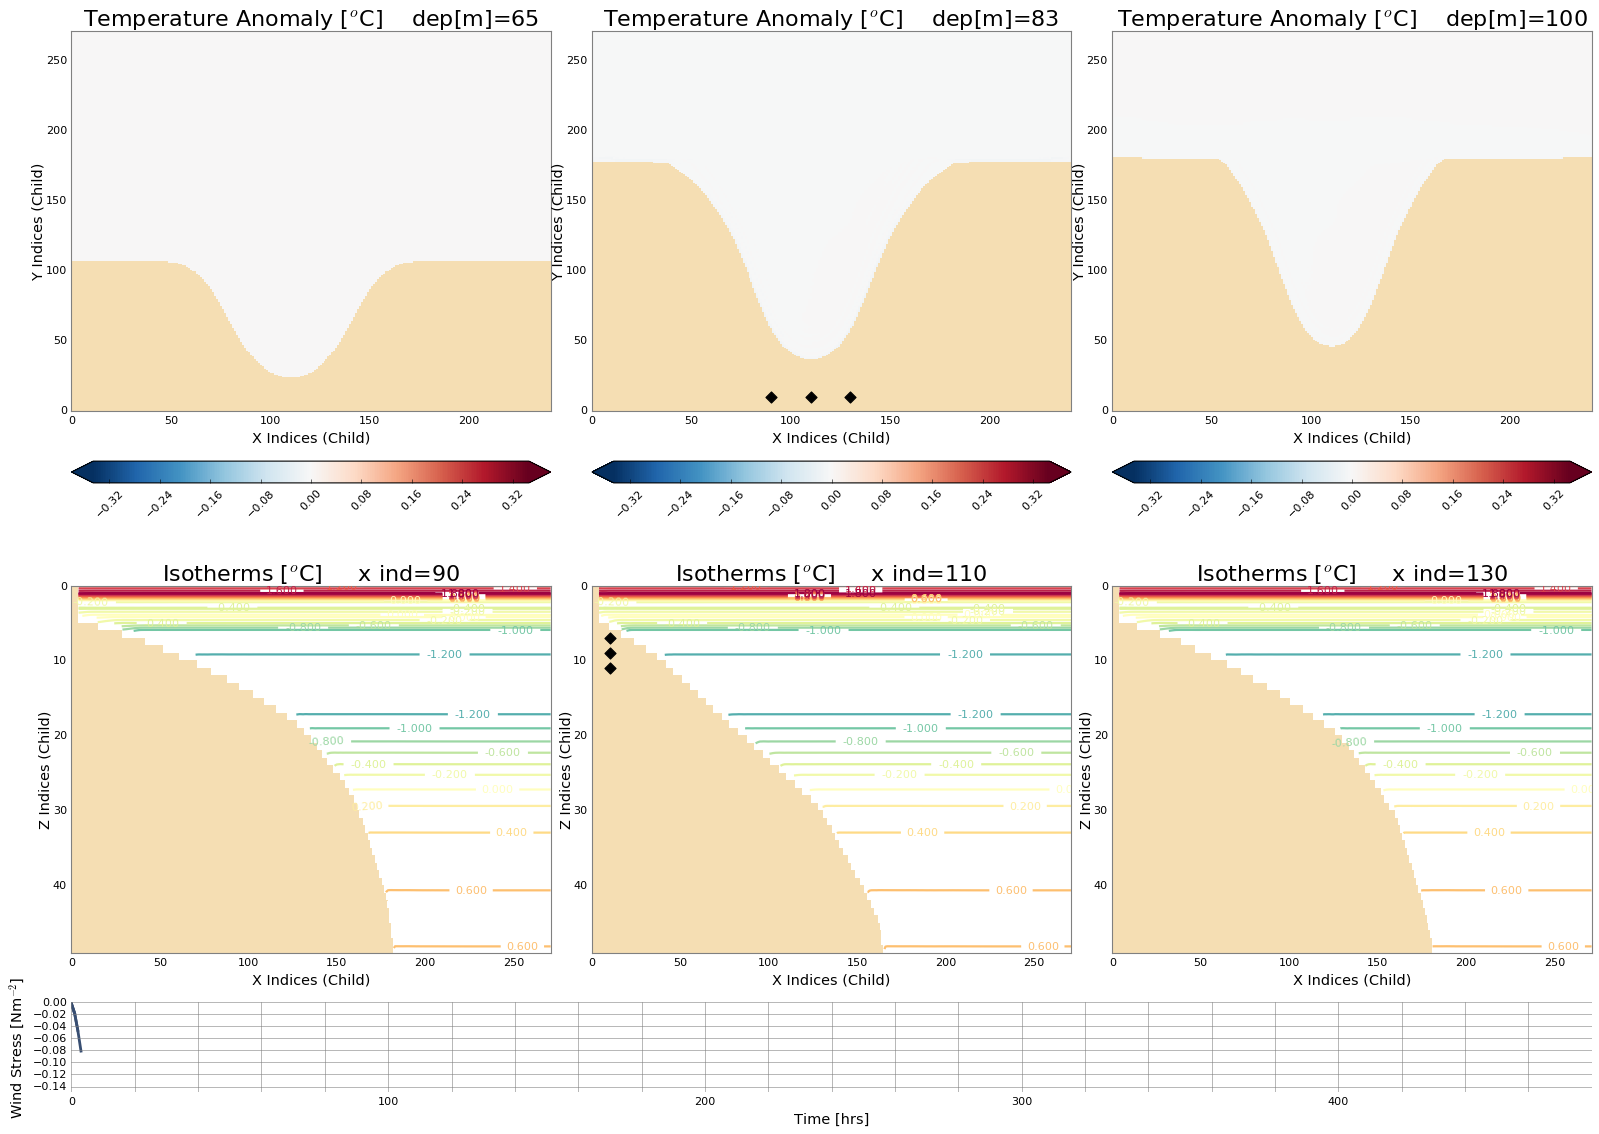

In [39]:
# 100 in 4 mins
fig = plt.figure(figsize=(20, 16))
ax1 = plt.subplot2grid((9, 12), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((9, 12), (0, 4), colspan=4, rowspan=4)
ax3 = plt.subplot2grid((9, 12), (0, 8), colspan=4, rowspan=4)

axA = plt.subplot2grid((9, 12), (4, 0), colspan=4, rowspan=3)
axB = plt.subplot2grid((9, 12), (4, 4), colspan=4, rowspan=3)
axC = plt.subplot2grid((9, 12), (4, 8), colspan=4, rowspan=3)

axa = plt.subplot2grid((9, 12), (7, 0), colspan=12)

axes = [ax1, ax2, ax3, axA, axB, axC]
fig, axes, axa = general_functions.set_plots(fig, axes, axa)
vm_top, levels_top = general_functions.get_limits(temp_anomA, temp_anomB, temp_anomC, 1, 10)
vm_cross, levels_cross = general_functions.get_limits(votemperA_c, votemperB_c, votemperC_c, 1, 19)

print(vm_top, levels_top)
print(vm_cross, levels_cross)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=3, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=5)
anim.save('temp.mp4', writer=writer)